# 協調フィルタリング: kNN回帰
## 0. はじめに
### 0.1. ゴール
- 協調フィルタリング（kNN回帰）を映画のレビューデータに実装して、レコメンドシステムを作成する。
    - 厳密には協調フィルタリングとkNN回帰は違うが、ロジックはほぼ一緒です。

## 1. 簡単な例で試してみる
### 1.1. イントロ
映画のレコメンドを考えてみましょう。映画「[ダークナイト](https://eiga.com/movie/53214/)」に対するTakutoさんの評価を予測してみます。アイデアとしては、Takutoさんと趣味嗜好が似ている人たちの評価をベースに予測します。（ユーザーベース）つまり、2つのタスクがあります。
- Takutoさんと他の人たちがどの程度趣味嗜好が似ているのかを定量的に評価する。
- 似ている度合いが高い人たちの評価を参考にTakutoさんの評価を予測する。

※元ネタは[こちら](https://blog.brainpad.co.jp/entry/2017/02/03/153000)です。Pythonに書き直しました。

In [45]:
# 必要なライブラリを一括で読み込み
import pandas as pd
from numpy import nan as NA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import matplotlib.patches as patches
from sklearn import neighbors

Section 1で扱うデータを作成します。ユーザー5人（Takutoさん, Koheiさん, Jouさん, Hajimeさん, Kojiさん）が5つの映画作品に対してレビューしたデータになっています。DataFrameの作り方についてはこちらを参考にしてください。

In [46]:
df = pd.DataFrame({'name':['Takuto','Kohei','Jou','Hajime','Koji'],
                   '作品1' : np.array([5,3,4,3,1]),
                   '作品2' : np.array([3,1,3,3,5]),
                   '作品3' : np.array([4,2,4,1,5]),
                   '作品4' : np.array([2,3,2,5,2]),
                   'ダークナイト' : np.array([np.NaN,3,5,4,1])})
df = df.set_index('name', drop=True)
df.head()

,作品1,作品2,作品3,作品4,ダークナイト
name,,,,,
Takuto,5,3,4,2,NaN
Kohei,3,1,2,3,3.0
Jou,4,3,4,2,5.0
Hajime,3,3,1,5,4.0
Koji,1,5,5,2,1.0


ヒートマップを使って可視化してみました。色の濃淡が似ているほど評価が似ていることを表します。Takutoさんと一番趣味嗜好が似ているのはどなたでしょう？？

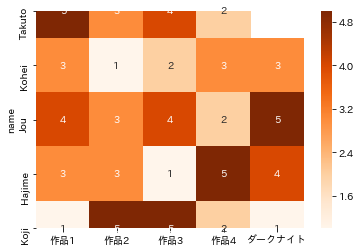

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))# 見た目を整える
sns.heatmap(df, annot=True, cmap='Oranges')
ax.set_ylim(len(df), 0) # 見た目を整える

### 1.2. ユークリッド距離
どの程度似ているのかを定量的に評価してみます！今回の大事なポイントです。評価の仕方は複数ありますが、ここではまずユークリッド距離で評価してみましょう。
※データの類似度の評価の仕方に関しては、[この資料](https://www.slideshare.net/SeiichiUchida/21-77833992)が分かりやすかったです。

早速、TakutoさんJouさんのユークリッド距離を計算してみましょう！まずは手計算で算出してみてください。その後、Pythonで計算していきます。

In [48]:
# Takutoさんの作品1の評価をデータフレームから抽出
df.iloc[0, 0]
# Jouさんの作品1の評価をデータフレームから抽出
df.iloc[2, 0]
# 作品1に関するユークリッド距離は
dist = (df.iloc[0, 0]-df.iloc[2, 0])**2
# これを作品2から作品4まで繰り返し、それらの和をとる
for i in range(1, 4) :
    dist_i = (df.iloc[0, i]-df.iloc[2, i])**2
    dist = dist + dist_i

print("TakutoさんとJouさんのユークリッド距離: ",dist)

TakutoさんとJouさんのユークリッド距離:  1


行列を用いると、もっと楽に早く計算することが可能に！データを扱うなら行列を学ぶべきです！自分も最近実感しました。

In [49]:
# 行列で計算
takuto = df.iloc[0, 0:4].values
print("Takutoさんのレビュー",takuto,sep=":")
jou = df.iloc[2, 0:4].values
print("Jouさんのレビュー: ",takuto)

# 距離計算
d_jou = np.sqrt(np.sum((takuto-jou)**2))
print("TakutoさんとJouさんのユークリッド距離: ",d_jou)

# コンパクトな関数もある 
np.linalg.norm(takuto - jou)

Takutoさんのレビュー:[5. 3. 4. 2.]
Jouさんのレビュー:  [5. 3. 4. 2.]
TakutoさんとJouさんのユークリッド距離:  1.0


1.0

これを全員分やると、、、

In [50]:
name = df.index
for i in range(5):
    print(name[i],np.linalg.norm(takuto - df.iloc[i, 0:4].values), sep = ":")

Takuto:0.0
Kohei:3.605551275463989
Jou:1.0
Hajime:4.69041575982343
Koji:4.58257569495584


ユークリッド距離をデータフレームに新しい変数として結合します。

In [51]:
df["eudist"] = [0.,0.,0.,0.,0.]
for i in range(5):
    df.iloc[i,5] = np.linalg.norm(takuto - df.iloc[i, 0:4].values)
df.head()                       

,作品1,作品2,作品3,作品4,ダークナイト,eudist
name,,,,,,
Takuto,5,3,4,2,NaN,0.000000
Kohei,3,1,2,3,3.0,3.605551
Jou,4,3,4,2,5.0,1.000000
Hajime,3,3,1,5,4.0,4.690416
Koji,1,5,5,2,1.0,4.582576


このユークリッド距離を可視化してみます。こんなイメージです。Takutoさんと距離が近ければ近いほど似ている度合いが高いです。

(-5.159457335805772, 5.159457335805772, -5.159457335805772, 5.159457335805772)

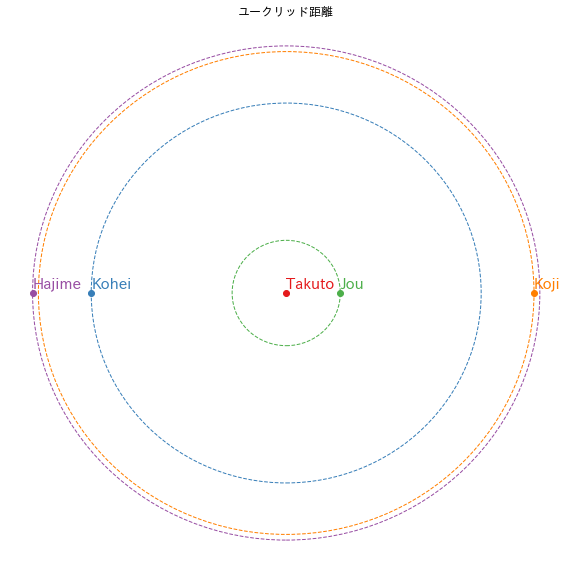

In [52]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']

plt.plot(df.iloc[0,5],0,"o", color = colorlist[0])
plt.text(df.iloc[0,5],0.1, name[0], color = colorlist[0], size = 15)
    
for i in range(1,5):
    c = patches.Circle(xy=(0, 0), radius= df.iloc[i,5], fill=False, linestyle = "dashed", ec = colorlist[i])
    ax.add_patch(c)
    plt.plot((-1)**i*df.iloc[i,5],0,"o", color = colorlist[i])
    plt.text((-1)**i*df.iloc[i,5],0.1, name[i], color = colorlist[i], size = 15)

plt.title("ユークリッド距離")
ax.axis("off")

### 1.3. 予測
さて、類似度が出ましたので、この中からTakutoさんと類似度の高いユーザを2人(JouさんとKoheiさん)選んで、ダークナイトに対する評価を推定します。類似度の高い人の評価をより重視するために、類似度を重みとして2人の平均評価値（加重平均）をとります。イメージは以下の通りです。

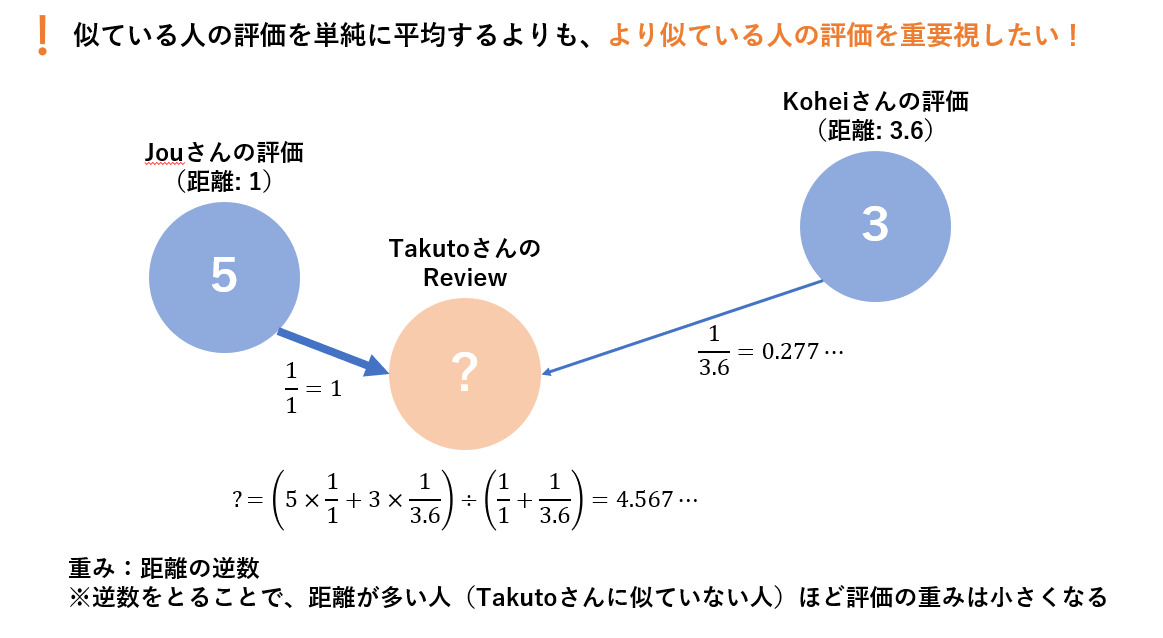

In [53]:
# ここでは、類似度の逆数をとります。
df["eudist_re"] = 1/df["eudist"]
sum(df.iloc[[1,2],4].values*df.iloc[[1,2],6].values)/sum(df.iloc[[1,2],6].values)

4.565741454089334

### 1.2. kNN回帰
kNN回帰を試してみます。先ほどまでと同じ結果が出てくるはずです。

In [54]:
df_matrix = df.values
# 学習用データ
x_train = df_matrix[1:5, 0:4]
y_train = df_matrix[1:5, 4]

# テストデータ
x_test = df_matrix[0, 0:4]

# モデル構築
knn2 = neighbors.KNeighborsRegressor(2, weights="distance", metric="euclidean")
model2 = knn2.fit(x_train, y_train)

# 予測
model2.predict([x_test])

array([4.56574145])

# 2. BigDataでトライしてみる
## 2.1. 前処理
データソースは[こちら](https://grouplens.org/datasets/movielens/)のLatest small dataになります。誰が、どんな映画に対して、どのような評価（1～5段階で0.5刻み）をしたかが記録されたデータです。

In [55]:
df_rating = pd.read_csv('ratings.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [56]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [57]:
df_movie = pd.read_csv('movies.csv')
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


movieIdで結合

In [58]:
df_merged = pd.merge(df_rating, df_movie, on = "movieId")
df_merged.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Chapter1の時と同様の形にデータを加工する。インデックスがユーザーで、カラムが映画になるようにする。

In [59]:
df_pivot = pd.pivot_table(df_merged, index = "userId", columns= "title", values = "rating")
df_pivot.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


欠損多いなぁ、一人当たりどんくらい見てるのか可視化しよう。

In [60]:
df_rating.groupby('userId').size().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64

Text(215.30491803278687, 350, 'mean')

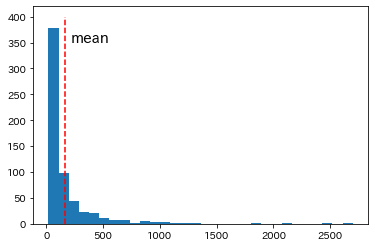

In [61]:
plt.hist(df_rating.groupby('userId').size(), bins= 30)
plt.vlines(df_rating.groupby('userId').size().mean(), 0, 400, "red", linestyle = "dashed")
plt.text(df_rating.groupby('userId').size().mean()+50, 350, "mean", size = 15)

うる覚えタイトル検索エンジン。正確なタイトルが必要なので、、

In [62]:
def searchmovie(name):
    print(df_movie[df_movie.title.str.contains(name,case=False)].title.unique())

In [63]:
searchmovie("logan")

["Logan's Run (1976)" 'Logan (2017)' 'Logan Lucky (2017)']


テストデータ、つまりレコメンドを出したい人の映画レビューを設定する。今回は自分で映画のレビューを10作品くらいしてみてください！

In [64]:
title = ['(500) Days of Summer (2009)', 'Dark Knight, The (2008)',
         'Inception (2010)', 'Edward Scissorhands (1990)', 
         'Whiplash (2014)','Eyes Wide Shut (1999)',
         'Predators (2010)', "The Hitman's Bodyguard (2017)",
         'The Martian (2015)', 'Logan (2017)']
score = [[5, 5, 5, 4, 4, 2.5, 2, 3, 3.5, 4.5]]
index = ["MY REVIEW"]
df_test = pd.DataFrame(data = score, index = index ,columns = title)
df_test.head()

,(500) Days of Summer (2009),"Dark Knight, The (2008)",Inception (2010),Edward Scissorhands (1990),Whiplash (2014),Eyes Wide Shut (1999),Predators (2010),The Hitman's Bodyguard (2017),The Martian (2015),Logan (2017)
MY REVIEW,5,5,5,4,4,2.5,2,3,3.5,4.5


もとのデータに結合しましょう

In [65]:
df_test_new = pd.concat([df_pivot, df_test], axis = 0, sort=False)
df_test_new.tail()

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,...,NaN,4.0,3.5,3.0,NaN,NaN,2.0,1.5,NaN,NaN
MY REVIEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


欠損値は０にしておく

In [67]:
df_test_new = df_test_new.fillna(0)
df_test_new.tail()

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0
609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,4.0,3.5,3.0,0.0,0.0,2.0,1.5,0.0,0.0
MY REVIEW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2.2. kNNで予測
自分がレビューした映画をもとに、自分に似ているユーザーを10人集める。彼らの評価をもとに、自分がレビューした映画以外のレビューを予測する。評価が高いものTop10を最終的に出力する。

In [68]:
# XとYに分ける
X = df_test_new[title].values 
Y = df_test_new.drop(title, axis = 1).values

# 学習用データ
x_train = X[0:610]
y_train = Y[0:610]


# テストデータ
x_test = X[610]

# モデル構築
knn10 = neighbors.KNeighborsRegressor(10, weights="distance", metric="euclidean")
model10 = knn10.fit(x_train, y_train)

# 予測
pred = model10.predict([x_test])
pred

array([[0.31221789, 0.        , 0.        , ..., 0.11708171, 1.39119185,
        0.        ]])

レコメンド結果の出力

In [72]:
recommend = pd.DataFrame(pred, columns=df_test_new.drop(title, axis = 1).columns)
recommend.sort_values(by = 0, axis=1, ascending=False, inplace=True) #降順に並び替える
recommend

,Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode IV - A New Hope (1977),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Fight Club (1999),"Matrix, The (1999)",Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Gladiator (2000),Guardians of the Galaxy (2014),Kill Bill: Vol. 1 (2003),...,Jesus of Montreal (Jésus de Montréal) (1989),Jesus Christ Superstar (1973),Jersey Boys (2014),"Jerky Boys, The (1995)",Jeremiah Johnson (1972),Jennifer's Body (2009),Jennifer 8 (1992),Jeffrey (1995),Jefferson in Paris (1995),À nous la liberté (Freedom for Us) (1931)
0,4.671284,4.640145,4.54727,4.512719,4.459821,4.405936,4.199433,4.180608,4.14306,4.132195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


上位10作品を出してみる。

In [75]:
for i in range(0, 10):
    print(i+1,",", recommend.columns[i], "point: ", round(recommend.iloc[0, i], 2) )

1 , Star Wars: Episode V - The Empire Strikes Back (1980) point:  4.67
2 , Star Wars: Episode VI - Return of the Jedi (1983) point:  4.64
3 , Star Wars: Episode IV - A New Hope (1977) point:  4.55
4 , Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) point:  4.51
5 , Fight Club (1999) point:  4.46
6 , Matrix, The (1999) point:  4.41
7 , Léon: The Professional (a.k.a. The Professional) (Léon) (1994) point:  4.2
8 , Gladiator (2000) point:  4.18
9 , Guardians of the Galaxy (2014) point:  4.14
10 , Kill Bill: Vol. 1 (2003) point:  4.13


今までの工程をまとめると、、

In [77]:
def recommendation(data):
    # テストデータを訓練データと結合
    df_test_new = pd.concat([df_pivot, data], axis = 0, sort=False)
    # 欠損値は0として扱う
    df_test_new = df_test_new.fillna(0)
    # XとYに分ける
    X = df_test_new[title].values 
    Y = df_test_new.drop(title, axis = 1).values

    # 学習用データ
    x_train = X[0:610]
    y_train = Y[0:610]


    # テストデータ
    x_test = X[610]

    # モデル構築
    knn10 = neighbors.KNeighborsRegressor(10, weights="distance", metric="euclidean")
    model10 = knn10.fit(x_train, y_train)

    # 予測
    pred = model10.predict([x_test])
    # 結果をデータフレーム化
    recommend = pd.DataFrame(pred, columns=df_test_new.drop(title, axis = 1).columns)
    recommend.sort_values(by = 0, axis=1, ascending=False, inplace=True) #降順に並び替える
    # 出力
    for i in range(0, 10):
        print(i+1,",", recommend.columns[i], "point: ", round(recommend.iloc[0, i], 2) )

今まで観てきた映画とその評価を入力すると、レコメンドが出てくるシステムっぽいやつが出来る。データの入力の段階がイケてないけど、多分ここからはWeb開発の話やUI・UXの話になってくると思います、、。レコメンドシステムの背後には、こういうシステムが回っているんだなぁと実感してもらえればありがたいです！

In [78]:
##### ここから
title = ['(500) Days of Summer (2009)', 'Dark Knight, The (2008)',
         'Inception (2010)', 'Edward Scissorhands (1990)', 
         'Whiplash (2014)','Eyes Wide Shut (1999)',
         'Predators (2010)', "The Hitman's Bodyguard (2017)",
         'The Martian (2015)', 'Logan (2017)']
score = [[5, 5, 5, 4, 4, 2.5, 2, 3, 3.5, 4.5]]
##### ここまで入力してください！

index = ["MY REVIEW"]
df_test = pd.DataFrame(data = score, index = index ,columns = title)
recommendation(df_test)

1 , Star Wars: Episode V - The Empire Strikes Back (1980) point:  4.67
2 , Star Wars: Episode VI - Return of the Jedi (1983) point:  4.64
3 , Star Wars: Episode IV - A New Hope (1977) point:  4.55
4 , Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) point:  4.51
5 , Fight Club (1999) point:  4.46
6 , Matrix, The (1999) point:  4.41
7 , Léon: The Professional (a.k.a. The Professional) (Léon) (1994) point:  4.2
8 , Gladiator (2000) point:  4.18
9 , Guardians of the Galaxy (2014) point:  4.14
10 , Kill Bill: Vol. 1 (2003) point:  4.13


## 今後に向けて
### まだまだ考えることはある
- ユーザーの類似度を算出する際に、ユーザーの属性情報なども追加するとより類似度が正確に予測できそう。
- ユーザーごとに評価の基準は異なるはず、、（バイアスの話。厳しくReviewする人もいれば、緩い人もいるはず）
- 今回は欠損値を0として扱ったが、本当に0で良いのか？
- 近傍の数は10で良いのか？
    - 近傍の数が多いほど、